In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Evaluation of test set for all codebooks

### B1.0

In [2]:
#B1.0
path_B1 = 'STRING_RESULT/B1.0/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B1_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [25]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B1 = B1_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B1.shape

(1250, 6)

In [26]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B1['unique_id'].unique().tolist()

In [27]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [28]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'RELEVANCE_x', 'RELEVANCE_y')
report_S2 = generate_classification_report(FB1S2, 'RELEVANCE_x', 'RELEVANCE_y')
report_S3 = generate_classification_report(FB1S3, 'RELEVANCE_x', 'RELEVANCE_y')
report_S4 = generate_classification_report(FB1S4, 'RELEVANCE_x', 'RELEVANCE_y')
report_S5 = generate_classification_report(FB1S5, 'RELEVANCE_x', 'RELEVANCE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                     precision    recall  f1-score  support
Not relevant          0.862745  0.550000  0.671756  160.000
Relevant              0.268817  0.714286  0.390625   35.000
Statement of intent   0.509091  0.509091  0.509091   55.000
accuracy              0.564000  0.564000  0.564000    0.564
macro avg             0.546884  0.591126  0.523824  250.000
weighted avg          0.701791  0.564000  0.596611  250.000


Classification Report for S2
                     precision    recall  f1-score  support
Not relevant          0.859813  0.575000  0.689139  160.000
Relevant              0.274725  0.714286  0.396825   35.000
Statement of intent   0.500000  0.472727  0.485981   55.000
accuracy              0.572000  0.572000  0.572000    0.572
macro avg             0.544846  0.587338  0.523982  250.000
weighted avg          0.698742  0.572000  0.603520  250.000


Classification Report for S3
                     precision    recall  f1-score  support
Not relev

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [30]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['RELEVANCE_y'].nunique() != 1


# Group by 'ID' and filter groups
B1_consistency = filtered_B1.groupby('unique_id').filter(relevance_y_not_uniform)

B1_consistency.shape

(135, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [33]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B1.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'RELEVANCE_y']}
agg_dict['RELEVANCE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B1_grouped = filtered_B1.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B1_grouped

,unique_id,text,RELEVANCE_x,llm_query,iteration,RELEVANCE_y
0,0, The U.S. has led the way in the relief effo...,Not relevant,0  The U.S. has led the way in the relief ef...,1,Not relevant
1,1,"Inthe past 10 years, the U.S. has contributed ...",Not relevant,"1 Inthe past 10 years, the U.S. has contribute...",1,Not relevant
2,2," Of course, scientists dont know that clima...",Not relevant,"2  Of course, scientists dont know that cli...",1,Relevant
3,3, It is for this reason that President Obama ...,Not relevant,3  It is for this reason that President Obam...,1,Statement of intent
4,4," Last June, President Obama announced the U....",Not relevant,"4  Last June, President Obama announced the ...",1,Not relevant
...,...,...,...,...,...,...
245,325,"Mr. President, Your Excellencies, Ladies and...",Relevant,"325 Mr. President, Your Excellencies, Ladies...",1,Relevant
246,326,The most important result of COP28 that I wou...,Statement of intent,326 The most important result of COP28 that I...,1,Relevant
247,327,"Trust that “WE” , governments together with o...",Statement of intent,"327 Trust that “WE” , governments together wi...",1,Relevant
248,329,"But for that, we need….to scale up the solutio...",Statement of intent,"329 But for that, we need….to scale up the sol...",1,Relevant


In [34]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B1_grouped['RELEVANCE_x'],filtered_B1_grouped['RELEVANCE_y']))

                     precision    recall  f1-score   support

       Not relevant       0.86      0.57      0.69       160
           Relevant       0.27      0.71      0.39        35
Statement of intent       0.49      0.44      0.46        55

           accuracy                           0.56       250
          macro avg       0.54      0.58      0.51       250
       weighted avg       0.70      0.56      0.60       250



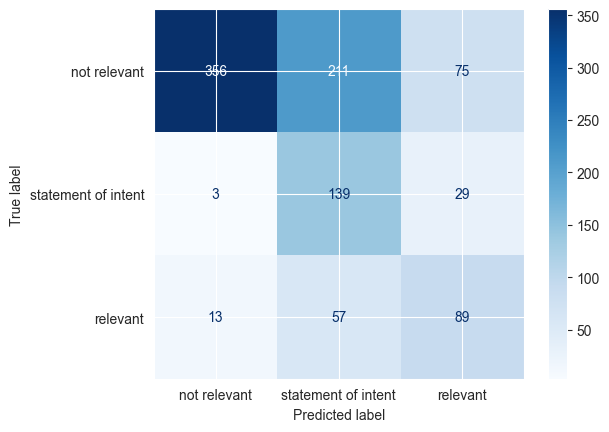

In [32]:
# Evaluate confusionmatrix for this aggregated set
labels = ['not relevant', 'statement of intent', 'relevant']

cm = confusion_matrix(filtered_B1_grouped['RELEVANCE_x'],filtered_B1_grouped['RELEVANCE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)


### B1.0.1

In [35]:
#B1.0
path_B1 = 'STRING_RESULT/B1.0.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B1_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [36]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B1 = B1_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B1.shape

(1350, 6)

In [37]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B1['unique_id'].unique().tolist()

In [38]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [39]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'RELEVANCE_x', 'RELEVANCE_y')
report_S2 = generate_classification_report(FB1S2, 'RELEVANCE_x', 'RELEVANCE_y')
report_S3 = generate_classification_report(FB1S3, 'RELEVANCE_x', 'RELEVANCE_y')
report_S4 = generate_classification_report(FB1S4, 'RELEVANCE_x', 'RELEVANCE_y')
report_S5 = generate_classification_report(FB1S5, 'RELEVANCE_x', 'RELEVANCE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                     precision    recall  f1-score     support
Not relevant          0.913978  0.480226  0.629630  177.000000
Relevant              0.226562  0.707317  0.343195   41.000000
Statement of intent   0.489796  0.461538  0.475248   52.000000
accuracy              0.511111  0.511111  0.511111    0.511111
macro avg             0.543446  0.549694  0.482691  270.000000
weighted avg          0.727899  0.511111  0.556401  270.000000


Classification Report for S2
                     precision    recall  f1-score     support
Not relevant          0.894737  0.480226  0.625000  177.000000
Relevant              0.235772  0.707317  0.353659   41.000000
Statement of intent   0.500000  0.500000  0.500000   52.000000
accuracy              0.518519  0.518519  0.518519    0.518519
macro avg             0.543503  0.562514  0.492886  270.000000
weighted avg          0.718648  0.518519  0.559722  270.000000


Classification Report for S3
                     precis

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [40]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['RELEVANCE_y'].nunique() != 1


# Group by 'ID' and filter groups
B1_consistency = filtered_B1.groupby('unique_id').filter(relevance_y_not_uniform)

B1_consistency.shape

(260, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [41]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B1.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'RELEVANCE_y']}
agg_dict['RELEVANCE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B1_grouped = filtered_B1.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B1_grouped

,unique_id,text,RELEVANCE_x,llm_query,iteration,RELEVANCE_y
0,0, The U.S. has led the way in the relief effo...,Not relevant,0  The U.S. has led the way in the relief ef...,1,Not relevant
1,1,"Inthe past 10 years, the U.S. has contributed ...",Not relevant,"1 Inthe past 10 years, the U.S. has contribute...",1,Not relevant
2,2," Of course, scientists dont know that clima...",Not relevant,"2  Of course, scientists dont know that cli...",1,Relevant
3,3, It is for this reason that President Obama ...,Not relevant,3  It is for this reason that President Obam...,1,Statement of intent
4,4," Last June, President Obama announced the U....",Not relevant,"4  Last June, President Obama announced the ...",1,Statement of intent
...,...,...,...,...,...,...
265,325,"Mr. President, Your Excellencies, Ladies and...",Relevant,"325 Mr. President, Your Excellencies, Ladies...",1,Relevant
266,326,The most important result of COP28 that I wou...,Statement of intent,326 The most important result of COP28 that I...,1,Statement of intent
267,327,"Trust that “WE” , governments together with o...",Statement of intent,"327 Trust that “WE” , governments together wi...",1,Relevant
268,329,"But for that, we need….to scale up the solutio...",Statement of intent,"329 But for that, we need….to scale up the sol...",1,Relevant


In [42]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B1_grouped['RELEVANCE_x'],filtered_B1_grouped['RELEVANCE_y']))

                     precision    recall  f1-score   support

       Not relevant       0.90      0.47      0.62       177
           Relevant       0.23      0.68      0.34        41
Statement of intent       0.46      0.48      0.47        52

           accuracy                           0.51       270
          macro avg       0.53      0.55      0.48       270
       weighted avg       0.72      0.51      0.55       270



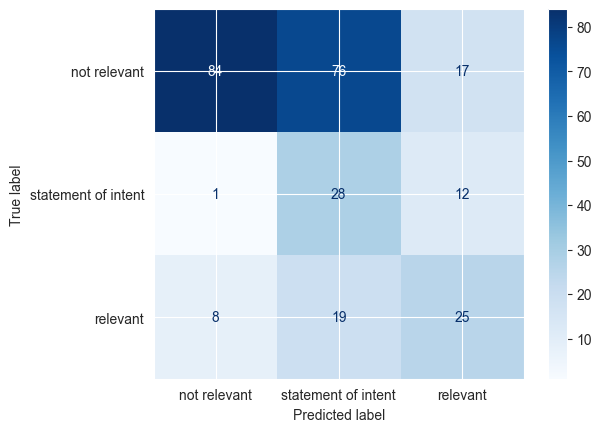

In [43]:
# Evaluate confusionmatrix for this aggregated set
labels = ['not relevant', 'statement of intent', 'relevant']

cm = confusion_matrix(filtered_B1_grouped['RELEVANCE_x'],filtered_B1_grouped['RELEVANCE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)


### B1.1

In [11]:
#B1.0
path_B1 = 'STRING_RESULT/B1.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B1_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [12]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B1 = B1_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B1.shape

(1450, 6)

In [13]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B1['unique_id'].unique().tolist()

In [14]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [15]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'RELEVANCE_x', 'RELEVANCE_y')
report_S2 = generate_classification_report(FB1S2, 'RELEVANCE_x', 'RELEVANCE_y')
report_S3 = generate_classification_report(FB1S3, 'RELEVANCE_x', 'RELEVANCE_y')
report_S4 = generate_classification_report(FB1S4, 'RELEVANCE_x', 'RELEVANCE_y')
report_S5 = generate_classification_report(FB1S5, 'RELEVANCE_x', 'RELEVANCE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                     precision    recall  f1-score     support
Not relevant          0.882353  0.552632  0.679612  190.000000
Relevant              0.270833  0.666667  0.385185   39.000000
Statement of intent   0.440000  0.540984  0.485294   61.000000
accuracy              0.565517  0.565517  0.565517    0.565517
macro avg             0.531062  0.586761  0.516697  290.000000
weighted avg          0.707067  0.565517  0.599143  290.000000


Classification Report for S2
                     precision    recall  f1-score     support
Not relevant          0.875000  0.552632  0.677419  190.000000
Relevant              0.284211  0.692308  0.402985   39.000000
Statement of intent   0.466667  0.573770  0.514706   61.000000
accuracy              0.575862  0.575862  0.575862    0.575862
macro avg             0.541959  0.606237  0.531703  290.000000
weighted avg          0.709658  0.575862  0.606287  290.000000


Classification Report for S3
                     precis

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [16]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['RELEVANCE_y'].nunique() != 1


# Group by 'ID' and filter groups
B1_consistency = filtered_B1.groupby('unique_id').filter(relevance_y_not_uniform)

B1_consistency.shape

(140, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [17]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B1.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'RELEVANCE_y']}
agg_dict['RELEVANCE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B1_grouped = filtered_B1.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B1_grouped

,unique_id,text,RELEVANCE_x,llm_query,iteration,RELEVANCE_y
0,0, The U.S. has led the way in the relief effo...,Not relevant,0  The U.S. has led the way in the relief ef...,1,Not relevant
1,1,"Inthe past 10 years, the U.S. has contributed ...",Not relevant,"1 Inthe past 10 years, the U.S. has contribute...",1,Not relevant
2,2," Of course, scientists dont know that clima...",Not relevant,"2  Of course, scientists dont know that cli...",1,Relevant
3,3, It is for this reason that President Obama ...,Not relevant,3  It is for this reason that President Obam...,1,Statement of intent
4,4," Last June, President Obama announced the U....",Not relevant,"4  Last June, President Obama announced the ...",1,Not relevant
...,...,...,...,...,...,...
285,325,"Mr. President, Your Excellencies, Ladies and...",Relevant,"325 Mr. President, Your Excellencies, Ladies...",1,Relevant
286,326,The most important result of COP28 that I wou...,Statement of intent,326 The most important result of COP28 that I...,1,Statement of intent
287,327,"Trust that “WE” , governments together with o...",Statement of intent,"327 Trust that “WE” , governments together wi...",1,Relevant
288,329,"But for that, we need….to scale up the solutio...",Statement of intent,"329 But for that, we need….to scale up the sol...",1,Relevant


In [18]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B1_grouped['RELEVANCE_x'],filtered_B1_grouped['RELEVANCE_y']))

                     precision    recall  f1-score   support

       Not relevant       0.88      0.55      0.68       190
           Relevant       0.27      0.67      0.38        39
Statement of intent       0.45      0.56      0.50        61

           accuracy                           0.57       290
          macro avg       0.53      0.59      0.52       290
       weighted avg       0.71      0.57      0.60       290



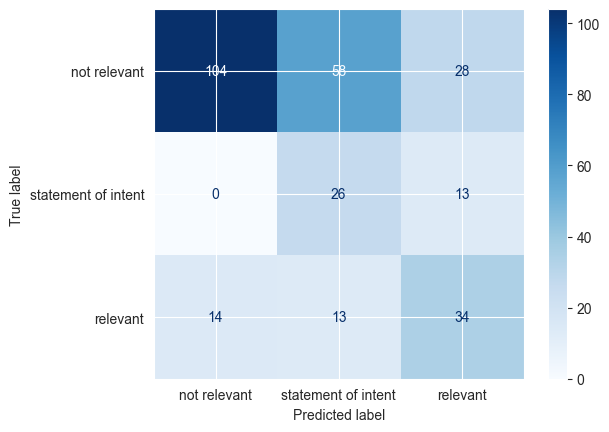

In [19]:
# Evaluate confusionmatrix for this aggregated set
labels = ['not relevant', 'statement of intent', 'relevant']

cm = confusion_matrix(filtered_B1_grouped['RELEVANCE_x'],filtered_B1_grouped['RELEVANCE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)


### B1.1.1

In [2]:
#B1.0
path_B1 = 'STRING_RESULT/B1.1.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B1_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [3]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B1 = B1_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B1.shape

(1650, 6)

In [4]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B1['unique_id'].unique().tolist()

In [5]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [6]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'RELEVANCE_x', 'RELEVANCE_y')
report_S2 = generate_classification_report(FB1S2, 'RELEVANCE_x', 'RELEVANCE_y')
report_S3 = generate_classification_report(FB1S3, 'RELEVANCE_x', 'RELEVANCE_y')
report_S4 = generate_classification_report(FB1S4, 'RELEVANCE_x', 'RELEVANCE_y')
report_S5 = generate_classification_report(FB1S5, 'RELEVANCE_x', 'RELEVANCE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                     precision    recall  f1-score     support
Not relevant          0.878571  0.580189  0.698864  212.000000
Relevant              0.285714  0.693878  0.404762   49.000000
Statement of intent   0.492958  0.507246  0.500000   69.000000
accuracy              0.581818  0.581818  0.581818    0.581818
macro avg             0.552414  0.593771  0.534542  330.000000
weighted avg          0.709913  0.581818  0.613613  330.000000


Classification Report for S2
                     precision    recall  f1-score     support
Not relevant          0.877863  0.542453  0.670554  212.000000
Relevant              0.266129  0.673469  0.381503   49.000000
Statement of intent   0.480000  0.521739  0.500000   69.000000
accuracy              0.557576  0.557576  0.557576    0.557576
macro avg             0.541331  0.579220  0.517352  330.000000
weighted avg          0.703840  0.557576  0.591973  330.000000


Classification Report for S3
                     precis

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [7]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['RELEVANCE_y'].nunique() != 1


# Group by 'ID' and filter groups
B1_consistency = filtered_B1.groupby('unique_id').filter(relevance_y_not_uniform)

B1_consistency.shape

(225, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [9]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B1.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'RELEVANCE_y']}
agg_dict['RELEVANCE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B1_grouped = filtered_B1.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B1_grouped

,unique_id,text,RELEVANCE_x,llm_query,iteration,RELEVANCE_y
0,0, The U.S. has led the way in the relief effo...,Not relevant,0  The U.S. has led the way in the relief ef...,1,Not relevant
1,1,"Inthe past 10 years, the U.S. has contributed ...",Not relevant,"1 Inthe past 10 years, the U.S. has contribute...",1,Not relevant
2,2," Of course, scientists dont know that clima...",Not relevant,"2  Of course, scientists dont know that cli...",1,Relevant
3,3, It is for this reason that President Obama ...,Not relevant,3  It is for this reason that President Obam...,1,Statement of intent
4,4," Last June, President Obama announced the U....",Not relevant,"4  Last June, President Obama announced the ...",1,Not relevant
...,...,...,...,...,...,...
325,325,"Mr. President, Your Excellencies, Ladies and...",Relevant,"325 Mr. President, Your Excellencies, Ladies...",1,Relevant
326,326,The most important result of COP28 that I wou...,Statement of intent,326 The most important result of COP28 that I...,1,Statement of intent
327,327,"Trust that “WE” , governments together with o...",Statement of intent,"327 Trust that “WE” , governments together wi...",1,Relevant
328,329,"But for that, we need….to scale up the solutio...",Statement of intent,"329 But for that, we need….to scale up the sol...",1,Relevant


In [10]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B1_grouped['RELEVANCE_x'],filtered_B1_grouped['RELEVANCE_y']))

                     precision    recall  f1-score   support

       Not relevant       0.88      0.58      0.70       212
           Relevant       0.30      0.73      0.42        49
Statement of intent       0.51      0.51      0.51        69

           accuracy                           0.58       330
          macro avg       0.56      0.61      0.54       330
       weighted avg       0.71      0.58      0.62       330



### B2.0

In [3]:
#B1.0
path_B2 = 'STRING_RESULT/B2.0/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B2_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [4]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B2 = B2_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B2.shape

(245, 6)

In [5]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B2['unique_id'].unique().tolist()

In [6]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [7]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score    support
egalitarian                   0.733333  0.687500  0.709677  16.000000
general normative statement   0.800000  0.250000  0.380952  16.000000
libertarian                   0.000000  0.000000  0.000000   3.000000
prioritarian                  0.600000  1.000000  0.750000   6.000000
sufficientarian               0.000000  0.000000  0.000000   2.000000
utilitarian                   0.235294  0.666667  0.347826   6.000000
accuracy                      0.510204  0.510204  0.510204   0.510204
macro avg                     0.394771  0.434028  0.364743  49.000000
weighted avg                  0.602961  0.510204  0.490552  49.000000


Classification Report for S2
                             precision    recall  f1-score    support
egalitarian                   0.733333  0.687500  0.709677  16.000000
general normative statement   0.800000  0.250000  0.380952  16.000000
libertarian                   

C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetric

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [10]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B2_consistency = filtered_B2.groupby('unique_id').filter(relevance_y_not_uniform)

B2_consistency.shape

(25, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [11]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B2.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B2_grouped = filtered_B2.groupby('unique_id').agg(agg_dict).reset_index()


In [14]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.73      0.69      0.71        16
general normative statement       0.80      0.25      0.38        16
                libertarian       0.00      0.00      0.00         3
               prioritarian       0.67      1.00      0.80         6
            sufficientarian       0.00      0.00      0.00         2
                utilitarian       0.22      0.67      0.33         6

                   accuracy                           0.51        49
                  macro avg       0.40      0.43      0.37        49
               weighted avg       0.61      0.51      0.49        49



C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### B2.1

In [25]:
#B1.0
path_B2 = 'STRING_RESULT/B2.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B2_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [26]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B2 = B2_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B2.shape

(245, 6)

In [17]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B2['unique_id'].unique().tolist()

In [18]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [20]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score    support
egalitarian                   0.687500  0.687500  0.687500  16.000000
general normative statement   0.727273  0.500000  0.592593  16.000000
libertarian                   1.000000  0.333333  0.500000   3.000000
prioritarian                  0.666667  1.000000  0.800000   6.000000
sufficientarian               0.000000  0.000000  0.000000   2.000000
utilitarian                   0.363636  0.666667  0.470588   6.000000
accuracy                      0.612245  0.612245  0.612245   0.612245
macro avg                     0.574179  0.531250  0.508447  49.000000
weighted avg                  0.649351  0.612245  0.604184  49.000000


Classification Report for S2
                             precision    recall  f1-score    support
egalitarian                   0.687500  0.687500  0.687500  16.000000
general normative statement   0.583333  0.437500  0.500000  16.000000
libertarian                   

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [22]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B1_consistency = filtered_B2.groupby('unique_id').filter(relevance_y_not_uniform)

B1_consistency.shape

(20, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [23]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B2.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B2_grouped = filtered_B2.groupby('unique_id').agg(agg_dict).reset_index()


In [24]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.69      0.69      0.69        16
general normative statement       0.73      0.50      0.59        16
                libertarian       1.00      0.33      0.50         3
               prioritarian       0.67      1.00      0.80         6
            sufficientarian       0.00      0.00      0.00         2
                utilitarian       0.36      0.67      0.47         6

                   accuracy                           0.61        49
                  macro avg       0.57      0.53      0.51        49
               weighted avg       0.65      0.61      0.60        49



### B2.1

In [25]:
#B1.0
path_B2 = 'STRING_RESULT/B2.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B2_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [26]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B2 = B2_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B2.shape

(245, 6)

In [17]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B2['unique_id'].unique().tolist()

In [18]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [20]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score    support
egalitarian                   0.687500  0.687500  0.687500  16.000000
general normative statement   0.727273  0.500000  0.592593  16.000000
libertarian                   1.000000  0.333333  0.500000   3.000000
prioritarian                  0.666667  1.000000  0.800000   6.000000
sufficientarian               0.000000  0.000000  0.000000   2.000000
utilitarian                   0.363636  0.666667  0.470588   6.000000
accuracy                      0.612245  0.612245  0.612245   0.612245
macro avg                     0.574179  0.531250  0.508447  49.000000
weighted avg                  0.649351  0.612245  0.604184  49.000000


Classification Report for S2
                             precision    recall  f1-score    support
egalitarian                   0.687500  0.687500  0.687500  16.000000
general normative statement   0.583333  0.437500  0.500000  16.000000
libertarian                   

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [22]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B1_consistency = filtered_B2.groupby('unique_id').filter(relevance_y_not_uniform)

B1_consistency.shape

(20, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [23]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B2.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B2_grouped = filtered_B2.groupby('unique_id').agg(agg_dict).reset_index()


In [24]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.69      0.69      0.69        16
general normative statement       0.73      0.50      0.59        16
                libertarian       1.00      0.33      0.50         3
               prioritarian       0.67      1.00      0.80         6
            sufficientarian       0.00      0.00      0.00         2
                utilitarian       0.36      0.67      0.47         6

                   accuracy                           0.61        49
                  macro avg       0.57      0.53      0.51        49
               weighted avg       0.65      0.61      0.60        49



### B3.0

In [27]:
#B1.0
path_B2 = 'STRING_RESULT/B3.0/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B2_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [28]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B2 = B2_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B2.shape

(1255, 6)

In [5]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B2['unique_id'].unique().tolist()

In [6]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [7]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score    support
egalitarian                   0.733333  0.687500  0.709677  16.000000
general normative statement   0.800000  0.250000  0.380952  16.000000
libertarian                   0.000000  0.000000  0.000000   3.000000
prioritarian                  0.600000  1.000000  0.750000   6.000000
sufficientarian               0.000000  0.000000  0.000000   2.000000
utilitarian                   0.235294  0.666667  0.347826   6.000000
accuracy                      0.510204  0.510204  0.510204   0.510204
macro avg                     0.394771  0.434028  0.364743  49.000000
weighted avg                  0.602961  0.510204  0.490552  49.000000


Classification Report for S2
                             precision    recall  f1-score    support
egalitarian                   0.733333  0.687500  0.709677  16.000000
general normative statement   0.800000  0.250000  0.380952  16.000000
libertarian                   

C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetric

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [29]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B2_consistency = filtered_B2.groupby('unique_id').filter(relevance_y_not_uniform)

B2_consistency.shape

(190, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [30]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B2.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B2_grouped = filtered_B2.groupby('unique_id').agg(agg_dict).reset_index()


In [31]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.43      0.90      0.58        10
general normative statement       0.11      0.54      0.19        13
                libertarian       0.00      0.00      0.00         1
              not evaluated       1.00      0.61      0.76       214
               prioritarian       0.42      0.83      0.56         6
            sufficientarian       0.00      0.00      0.00         1
                utilitarian       0.13      0.50      0.21         6

                   accuracy                           0.61       251
                  macro avg       0.30      0.48      0.33       251
               weighted avg       0.89      0.61      0.70       251



C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### B3.0.1

In [32]:
#B1.0
path_B2 = 'STRING_RESULT/B3.0.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B2_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [33]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B2 = B2_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B2.shape

(1550, 6)

In [5]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B2['unique_id'].unique().tolist()

In [6]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [7]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score    support
egalitarian                   0.733333  0.687500  0.709677  16.000000
general normative statement   0.800000  0.250000  0.380952  16.000000
libertarian                   0.000000  0.000000  0.000000   3.000000
prioritarian                  0.600000  1.000000  0.750000   6.000000
sufficientarian               0.000000  0.000000  0.000000   2.000000
utilitarian                   0.235294  0.666667  0.347826   6.000000
accuracy                      0.510204  0.510204  0.510204   0.510204
macro avg                     0.394771  0.434028  0.364743  49.000000
weighted avg                  0.602961  0.510204  0.490552  49.000000


Classification Report for S2
                             precision    recall  f1-score    support
egalitarian                   0.733333  0.687500  0.709677  16.000000
general normative statement   0.800000  0.250000  0.380952  16.000000
libertarian                   

C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetric

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [34]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B2_consistency = filtered_B2.groupby('unique_id').filter(relevance_y_not_uniform)

B2_consistency.shape

(215, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [35]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B2.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B2_grouped = filtered_B2.groupby('unique_id').agg(agg_dict).reset_index()


In [36]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.36      0.71      0.48        14
general normative statement       0.09      0.36      0.14        14
                libertarian       0.00      0.00      0.00         3
              not evaluated       0.98      0.62      0.76       265
               prioritarian       0.28      0.83      0.42         6
            sufficientarian       0.00      0.00      0.00         2
                utilitarian       0.08      0.50      0.14         6

                   accuracy                           0.60       310
                  macro avg       0.25      0.43      0.28       310
               weighted avg       0.86      0.60      0.69       310



C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### B3.1

In [2]:
#B1.0
path_B2 = 'STRING_RESULT/B3.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B2_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [3]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B2 = B2_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B2.shape

(950, 6)

In [4]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B2['unique_id'].unique().tolist()

In [5]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [7]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score    support
egalitarian                   0.733333  0.687500  0.709677  16.000000
general normative statement   0.800000  0.250000  0.380952  16.000000
libertarian                   0.000000  0.000000  0.000000   3.000000
prioritarian                  0.600000  1.000000  0.750000   6.000000
sufficientarian               0.000000  0.000000  0.000000   2.000000
utilitarian                   0.235294  0.666667  0.347826   6.000000
accuracy                      0.510204  0.510204  0.510204   0.510204
macro avg                     0.394771  0.434028  0.364743  49.000000
weighted avg                  0.602961  0.510204  0.490552  49.000000


Classification Report for S2
                             precision    recall  f1-score    support
egalitarian                   0.733333  0.687500  0.709677  16.000000
general normative statement   0.800000  0.250000  0.380952  16.000000
libertarian                   

C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetric

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [6]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B2_consistency = filtered_B2.groupby('unique_id').filter(relevance_y_not_uniform)

B2_consistency.shape

(165, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [7]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B2.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B2_grouped = filtered_B2.groupby('unique_id').agg(agg_dict).reset_index()


In [8]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.39      0.88      0.54         8
general normative statement       0.18      0.64      0.29        11
                libertarian       0.00      0.00      0.00         1
              not evaluated       1.00      0.71      0.83       157
               prioritarian       0.42      1.00      0.59         5
            sufficientarian       0.00      0.00      0.00         2
                utilitarian       0.20      0.33      0.25         6

                   accuracy                           0.69       190
                  macro avg       0.31      0.51      0.36       190
               weighted avg       0.87      0.69      0.75       190



C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### B3.1.1

In [9]:
#B1.0
path_B2 = 'STRING_RESULT/B3.1.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B2_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [10]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B2 = B2_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B2.shape

(1250, 6)

In [11]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B2['unique_id'].unique().tolist()

In [13]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [14]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score  support
egalitarian                   0.400000  0.769231  0.526316   13.000
general normative statement   0.166667  0.500000  0.250000   12.000
libertarian                   1.000000  0.333333  0.500000    3.000
not evaluated                 0.974359  0.723810  0.830601  210.000
prioritarian                  0.375000  1.000000  0.545455    6.000
sufficientarian               0.000000  0.000000  0.000000    1.000
utilitarian                   0.071429  0.200000  0.105263    5.000
accuracy                      0.704000  0.704000  0.704000    0.704
macro avg                     0.426779  0.503768  0.393948  250.000
weighted avg                  0.869690  0.704000  0.758270  250.000


Classification Report for S2
                             precision    recall  f1-score  support
egalitarian                   0.416667  0.769231  0.540541   13.000
general normative statement   0.136364  0.500000  0.2142

C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetric

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [15]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B2_consistency = filtered_B2.groupby('unique_id').filter(relevance_y_not_uniform)

B2_consistency.shape

(210, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [16]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B2.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B2_grouped = filtered_B2.groupby('unique_id').agg(agg_dict).reset_index()


In [17]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.40      0.77      0.53        13
general normative statement       0.16      0.50      0.24        12
                libertarian       0.00      0.00      0.00         3
              not evaluated       0.97      0.72      0.83       210
               prioritarian       0.33      0.83      0.48         6
            sufficientarian       0.00      0.00      0.00         1
                utilitarian       0.07      0.20      0.11         5

                   accuracy                           0.69       250
                  macro avg       0.28      0.43      0.31       250
               weighted avg       0.86      0.69      0.75       250



C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### B4.0

In [18]:
#B1.0
path_B2 = 'STRING_RESULT/B4.0/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B2_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [23]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B2 = B2_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B2

,unique_id,text,PRINCIPLE_x,TOPIC_x,UNIT_x,SHAPE_x,llm_query,PRINCIPLE_y,TOPIC_y,UNIT_y,SHAPE_y,iteration
0,0, The U.S. has led the way in the relief effo...,not evaluated,not evaluated,not evaluated,not evaluated,0  The U.S. has led the way in the relief ef...,not evaluated,not evaluated,not evaluated,not evaluated,1
1,1,"Inthe past 10 years, the U.S. has contributed ...",not evaluated,not evaluated,not evaluated,not evaluated,"1 Inthe past 10 years, the U.S. has contribute...",not evaluated,not evaluated,not evaluated,not evaluated,1
2,2," Of course, scientists dont know that clima...",not evaluated,not evaluated,not evaluated,not evaluated,"2  Of course, scientists dont know that cli...",utilitarian,urgency,not indicated,not indicated,1
3,3, It is for this reason that President Obama ...,not evaluated,not evaluated,not evaluated,not evaluated,3  It is for this reason that President Obam...,general normative statement,cooperation,responsibility,not indicated,1
4,4," Last June, President Obama announced the U....",not evaluated,not evaluated,not evaluated,not evaluated,"4  Last June, President Obama announced the ...",not evaluated,not evaluated,not evaluated,not evaluated,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1610,326,The most important result of COP28 that I wou...,not evaluated,not evaluated,not evaluated,not evaluated,326 The most important result of COP28 that I...,general normative statement,urgency,not indicated,not indicated,1
1611,327,"Trust that “WE” , governments together with o...",not evaluated,not evaluated,not evaluated,not evaluated,"327 Trust that “WE” , governments together wi...",egalitarian,UNFCCC agreements and principles,responsibility,equality,1
1612,328,,not evaluated,not evaluated,not evaluated,not evaluated,328 \n,not evaluated,not evaluated,not evaluated,not evaluated,1
1613,329,"But for that, we need….to scale up the solutio...",general normative statement,urgency,not indicated,not indicated,"329 But for that, we need….to scale up the sol...",general normative statement,urgency,not indicated,not indicated,1


In [25]:
filtered_B2.PRINCIPLE_y.value_counts()

not evaluated                  725
utilitarian                    226
general normative statement    207
egalitarian                    160
prioritarian                    63
sufficientarian                 46
urgency                         18
cooperation                     10
Name: PRINCIPLE_y, dtype: int64

In [20]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B2['unique_id'].unique().tolist()

In [21]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [14]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score  support
egalitarian                   0.400000  0.769231  0.526316   13.000
general normative statement   0.166667  0.500000  0.250000   12.000
libertarian                   1.000000  0.333333  0.500000    3.000
not evaluated                 0.974359  0.723810  0.830601  210.000
prioritarian                  0.375000  1.000000  0.545455    6.000
sufficientarian               0.000000  0.000000  0.000000    1.000
utilitarian                   0.071429  0.200000  0.105263    5.000
accuracy                      0.704000  0.704000  0.704000    0.704
macro avg                     0.426779  0.503768  0.393948  250.000
weighted avg                  0.869690  0.704000  0.758270  250.000


Classification Report for S2
                             precision    recall  f1-score  support
egalitarian                   0.416667  0.769231  0.540541   13.000
general normative statement   0.136364  0.500000  0.2142

C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetric

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [22]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B2_consistency = filtered_B2.groupby('unique_id').filter(relevance_y_not_uniform)

B2_consistency.shape

(315, 12)


In combined dataframe, groupyby unique ID and take the majority label

In [16]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B2.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B2_grouped = filtered_B2.groupby('unique_id').agg(agg_dict).reset_index()


In [17]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B2_grouped['PRINCIPLE_x'],filtered_B2_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.40      0.77      0.53        13
general normative statement       0.16      0.50      0.24        12
                libertarian       0.00      0.00      0.00         3
              not evaluated       0.97      0.72      0.83       210
               prioritarian       0.33      0.83      0.48         6
            sufficientarian       0.00      0.00      0.00         1
                utilitarian       0.07      0.20      0.11         5

                   accuracy                           0.69       250
                  macro avg       0.28      0.43      0.31       250
               weighted avg       0.86      0.69      0.75       250



C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
